In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=10, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

In [4]:
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,1217,1134,1
1,1648,7676,0
2,596,6649,0
3,475,237,1
4,1450,1707,0
...,...,...,...
42341,1778,4896,0
42342,519,9,1
42343,1487,10045,1
42344,1115,163,1


In [16]:
a_set = set()
for k, adj_list in kg.items():
    if len(adj_list) == 0:
        print(k)
    for rel, ent in adj_list:
        a_set.add(ent)
print(len(a_set))

9366


In [5]:
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [8]:
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
print(data_loader.get_num())
print(len(user_encoder.classes_), len(entity_encoder.classes_), len(relation_encoder.classes_))
print(len(kg))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)

(1872, 11012, 60)
1872 11012 60
9366
cuda:0


In [9]:
loss_list = []
test_loss_list = []
auc_score_list = []
for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate on every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

[Epoch 1]train_loss:  1.0653072730550226
[Epoch 1]test_loss:  1.007445897629012
[Epoch 2]train_loss:  0.9456337870291944
[Epoch 2]test_loss:  0.9043294209152904
[Epoch 3]train_loss:  0.8434718705573172
[Epoch 3]test_loss:  0.8174173369336484
[Epoch 4]train_loss:  0.7686108688138565
[Epoch 4]test_loss:  0.7573235880083112
[Epoch 5]train_loss:  0.7242474870861701
[Epoch 5]test_loss:  0.7245880436541429
[Epoch 6]train_loss:  0.7032090079109624
[Epoch 6]test_loss:  0.7096283293482083
[Epoch 7]train_loss:  0.6945475371378773
[Epoch 7]test_loss:  0.7031671689517462
[Epoch 8]train_loss:  0.6910126573634597
[Epoch 8]test_loss:  0.7002580325994918
[Epoch 9]train_loss:  0.6893630916217588
[Epoch 9]test_loss:  0.6988173047108437
[Epoch 10]train_loss:  0.6883687919040896
[Epoch 10]test_loss:  0.6980118707044801


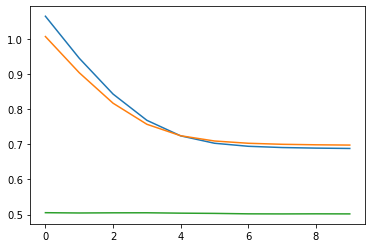

In [10]:
plt.plot(loss_list)
plt.plot(test_loss_list)
plt.plot(auc_score_list)
plt.show()

In [11]:
auc_score_list

[0.5052668707653531,
 0.5044303205309552,
 0.5048989975721498,
 0.5050129086373211,
 0.5039184630161978,
 0.5032616620110345,
 0.5019798119945791,
 0.5017658309691992,
 0.5020279589990785,
 0.501830942410062]